In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


from dotenv import load_dotenv
from sqlalchemy import create_engine

In [2]:
load_dotenv()

DATABASE_URL = os.getenv("DATABASE_URL")
engine = create_engine(DATABASE_URL)

def load_table(table_name, limit=None):
    query = f"SELECT * FROM {table_name}"
    if limit is not None:
        query += f" LIMIT {limit}"
    return pd.read_sql(query, engine)

In [3]:
def basic_eda(df, name):
    print(f"=== {name} ===")
    print("Shape:", df.shape)
    print("\nDtypes:")
    print(df.dtypes)
    
    print("\nMissing values (count):")
    print(df.isna().sum())
    
    print("\nMissing values (%):")
    print((df.isna().mean() * 100).round(2))
    
    # For numeric columns only
    num_cols = df.select_dtypes(include=[np.number]).columns
    if len(num_cols) > 0:
        print("\nNumeric summary:\n")
        display(df[num_cols].describe().T)
    
    # For object columns, show top categories
    obj_cols = df.select_dtypes(include=["object"]).columns
    for col in obj_cols:
        print(f"\nValue counts for {col} (top 5):")
        print(df[col].value_counts(dropna=False).head())
    
    print("\n" + "="*50 + "\n")

In [4]:
def check_key_uniqueness(df, cols, name):
    print(f"Checking key {cols} in {name}")
    dup_count = df.duplicated(subset=cols).sum()
    if dup_count == 0:
        print("✅ No duplicates for this key.")
    else:
        print(f"⚠️ Found {dup_count} duplicate rows for this key.")

In [5]:
customers = load_table("hpce.olist_customers")
basic_eda(customers, "olist_customers")

=== olist_customers ===
Shape: (99441, 5)

Dtypes:
customer_id                 object
customer_unique_id          object
customer_zip_code_prefix    object
customer_city               object
customer_state              object
dtype: object

Missing values (count):
customer_id                 0
customer_unique_id          0
customer_zip_code_prefix    0
customer_city               0
customer_state              0
dtype: int64

Missing values (%):
customer_id                 0.0
customer_unique_id          0.0
customer_zip_code_prefix    0.0
customer_city               0.0
customer_state              0.0
dtype: float64

Value counts for customer_id (top 5):
customer_id
84ded8b079a1aa215e8cf4c3399bcd37    1
8ab265b68e45adf3a9d8e7fd0df8815d    1
fdbf999a073957ff252e8f4897732299    1
fa7ec8b2b45b5b6517357a5c5e82740d    1
b58dcebd1080a35715998c1c6b9f4d81    1
Name: count, dtype: int64

Value counts for customer_unique_id (top 5):
customer_unique_id
8d50f5eadf50201ccdcedfb9e2ac8455    17
3e43e

In [6]:
# Check customer_id uniqueness
check_key_uniqueness(customers, ["customer_id"], "olist_customers")

# Check if any customer_id is null
print("Null customer_id:", customers["customer_id"].isna().sum())

Checking key ['customer_id'] in olist_customers
✅ No duplicates for this key.
Null customer_id: 0


In [7]:
orders = load_table("hpce.olist_orders")
basic_eda(orders, "olist_orders")

=== olist_orders ===
Shape: (99441, 8)

Dtypes:
order_id                       object
customer_id                    object
order_status                   object
order_purchase_ts              object
order_approved_ts              object
order_delivered_carrier_ts     object
order_delivered_customer_ts    object
order_estimated_delivery_ts    object
dtype: object

Missing values (count):
order_id                          0
customer_id                       0
order_status                      0
order_purchase_ts                 0
order_approved_ts               160
order_delivered_carrier_ts     1783
order_delivered_customer_ts    2965
order_estimated_delivery_ts       0
dtype: int64

Missing values (%):
order_id                       0.00
customer_id                    0.00
order_status                   0.00
order_purchase_ts              0.00
order_approved_ts              0.16
order_delivered_carrier_ts     1.79
order_delivered_customer_ts    2.98
order_estimated_delivery_ts    0.00

In [8]:
date_cols = [
    "order_purchase_ts",
    "order_approved_ts",
    "order_delivered_carrier_ts",
    "order_delivered_customer_ts",
    "order_estimated_delivery_ts",
]

for col in date_cols:
    if col in orders.columns:
        orders[col] = pd.to_datetime(orders[col], errors="coerce")

orders[date_cols].isna().sum()

order_purchase_ts              32641
order_approved_ts              32754
order_delivered_carrier_ts     33292
order_delivered_customer_ts    31334
order_estimated_delivery_ts    27608
dtype: int64

In [9]:
# PK: order_id
check_key_uniqueness(orders, ["order_id"], "olist_orders")

# FK: customer_id should exist in customers table
missing_customers = (
    orders[~orders["customer_id"].isin(customers["customer_id"])]
)
print("Orders with customer_id not in customers:", len(missing_customers))

Checking key ['order_id'] in olist_orders
✅ No duplicates for this key.
Orders with customer_id not in customers: 0


In [10]:
# Purchase -> delivered
valid_time = (
    (orders["order_purchase_ts"].notna()) &
    (orders["order_delivered_customer_ts"].notna())
)

time_diff = (
    orders.loc[valid_time, "order_delivered_customer_ts"] -
    orders.loc[valid_time, "order_purchase_ts"]
).dt.days

print("Min delivery days:", time_diff.min())
print("Max delivery days:", time_diff.max())
print("95th percentile:", time_diff.quantile(0.95))

Min delivery days: 0
Max delivery days: 189
95th percentile: 24.0


In [11]:
orders["delivery_days"] = time_diff
bad_delivery = orders[orders["delivery_days"] < 0]
print("Negative delivery days rows:", bad_delivery.shape[0])

Negative delivery days rows: 0


In [12]:
orders["delivery_days"] = time_diff
bad_delivery = orders[orders["delivery_days"] > 180]
print("Extreme delivery days rows:", bad_delivery.shape[0])

Extreme delivery days rows: 5


In [13]:
order_items = load_table("hpce.olist_order_items")
basic_eda(order_items, "olist_order_items")

=== olist_order_items ===
Shape: (112650, 7)

Dtypes:
order_id                object
order_item_id            int64
product_id              object
seller_id               object
shipping_limit_date     object
price                  float64
freight_value          float64
dtype: object

Missing values (count):
order_id               0
order_item_id          0
product_id             0
seller_id              0
shipping_limit_date    0
price                  0
freight_value          0
dtype: int64

Missing values (%):
order_id               0.0
order_item_id          0.0
product_id             0.0
seller_id              0.0
shipping_limit_date    0.0
price                  0.0
freight_value          0.0
dtype: float64

Numeric summary:



,count,mean,std,min,25%,50%,75%,max
order_item_id,112650.0,1.197834,0.705124,1.00,1.00,1.00,1.00,21.00
price,112650.0,120.653739,183.633928,0.85,39.90,74.99,134.90,6735.00
freight_value,112650.0,19.990320,15.806405,0.00,13.08,16.26,21.15,409.68



Value counts for order_id (top 5):
order_id
8272b63d03f5f79c56e9e4120aec44ef    21
1b15974a0141d54e36626dca3fdc731a    20
ab14fdcfbe524636d65ee38360e22ce8    20
9ef13efd6949e4573a18964dd1bbe7f5    15
428a2f660dc84138d969ccd69a0ab6d5    15
Name: count, dtype: int64

Value counts for product_id (top 5):
product_id
aca2eb7d00ea1a7b8ebd4e68314663af    527
99a4788cb24856965c36a24e339b6058    488
422879e10f46682990de24d770e7f83d    484
389d119b48cf3043d311335e499d9c6b    392
368c6c730842d78016ad823897a372db    388
Name: count, dtype: int64

Value counts for seller_id (top 5):
seller_id
6560211a19b47992c3666cc44a7e94c0    2033
4a3ca9315b744ce9f8e9374361493884    1987
1f50f920176fa81dab994f9023523100    1931
cc419e0650a3c5ba77189a1882b7556a    1775
da8622b14eb17ae2831f4ac5b9dab84a    1551
Name: count, dtype: int64

Value counts for shipping_limit_date (top 5):
shipping_limit_date
2017-07-21 18:25:23-07:00    21
2018-03-01 02:50:48-08:00    21
2017-08-30 14:30:23-07:00    20
2017-12-21 02:30:4

In [14]:
check_key_uniqueness(order_items, ["order_id", "order_item_id"], "olist_order_items")

Checking key ['order_id', 'order_item_id'] in olist_order_items
✅ No duplicates for this key.


In [15]:
# Orders that appear in items but missing from orders table
missing_orders = order_items[~order_items["order_id"].isin(orders["order_id"])]
print("Order_items with missing order in orders:", len(missing_orders))

# Products that appear in items but missing from products table (later when products loaded)

Order_items with missing order in orders: 0


In [16]:
# Negative or zero prices
print("Items with non-positive price:", (order_items["price"] <= 0).sum())
print("Items with negative freight:", (order_items["freight_value"] < 0).sum())

# Distribution of price
order_items["price"].describe()

Items with non-positive price: 0
Items with negative freight: 0


count    112650.000000
mean        120.653739
std         183.633928
min           0.850000
25%          39.900000
50%          74.990000
75%         134.900000
max        6735.000000
Name: price, dtype: float64

In [17]:
def flag_outliers_iqr(series):
    q1 = series.quantile(0.25)
    q3 = series.quantile(0.75)
    iqr = q3 - q1
    lower = q1 - 1.5 * iqr
    upper = q3 + 1.5 * iqr
    return (series < lower) | (series > upper)

price_outliers = flag_outliers_iqr(order_items["price"])
print("Num price outliers:", price_outliers.sum())

Num price outliers: 8427


In [18]:
products = load_table("hpce.olist_products")
basic_eda(products, "olist_products")

=== olist_products ===
Shape: (32951, 9)

Dtypes:
product_id                     object
product_category_name          object
product_name_length           float64
product_description_length    float64
product_photos_qty            float64
product_weight_g              float64
product_length_cm             float64
product_height_cm             float64
product_width_cm              float64
dtype: object

Missing values (count):
product_id                      0
product_category_name         610
product_name_length           610
product_description_length    610
product_photos_qty            610
product_weight_g                2
product_length_cm               2
product_height_cm               2
product_width_cm                2
dtype: int64

Missing values (%):
product_id                    0.00
product_category_name         1.85
product_name_length           1.85
product_description_length    1.85
product_photos_qty            1.85
product_weight_g              0.01
product_length_cm  

,count,mean,std,min,25%,50%,75%,max
product_name_length,32341.0,48.476949,10.245741,5.0,42.0,51.0,57.0,76.0
product_description_length,32341.0,771.495285,635.115225,4.0,339.0,595.0,972.0,3992.0
product_photos_qty,32341.0,2.188986,1.736766,1.0,1.0,1.0,3.0,20.0
product_weight_g,32949.0,2276.472488,4282.038731,0.0,300.0,700.0,1900.0,40425.0
product_length_cm,32949.0,30.815078,16.914458,7.0,18.0,25.0,38.0,105.0
product_height_cm,32949.0,16.937661,13.637554,2.0,8.0,13.0,21.0,105.0
product_width_cm,32949.0,23.196728,12.079047,6.0,15.0,20.0,30.0,118.0



Value counts for product_id (top 5):
product_id
9a3a682d9257657cf55214a390ecbf3c    1
0ee300fb7a6715fdac77e6fb6e7e37f3    1
4ef061c259138e88ac20204e453f201c    1
908071e6f99433fe356fcfaa41fd1d1e    1
f4d640751dc4c32a4338ad7dd111fe48    1
Name: count, dtype: int64

Value counts for product_category_name (top 5):
product_category_name
cama_mesa_banho          3029
esporte_lazer            2867
moveis_decoracao         2657
beleza_saude             2444
utilidades_domesticas    2335
Name: count, dtype: int64




In [19]:
check_key_uniqueness(products, ["product_id"], "olist_products")

Checking key ['product_id'] in olist_products
✅ No duplicates for this key.


In [20]:
missing_products = order_items[~order_items["product_id"].isin(products["product_id"])]
print("Order_items with product_id not in products:", len(missing_products))

Order_items with product_id not in products: 0


In [21]:
num_cols = [
    "product_weight_g",
    "product_length_cm",
    "product_height_cm",
    "product_width_cm",
]

products[num_cols].describe()

# Negative or zero values?
for col in num_cols:
    print(col, "non-positive count:", (products[col] <= 0).sum())

product_weight_g non-positive count: 4
product_length_cm non-positive count: 0
product_height_cm non-positive count: 0
product_width_cm non-positive count: 0


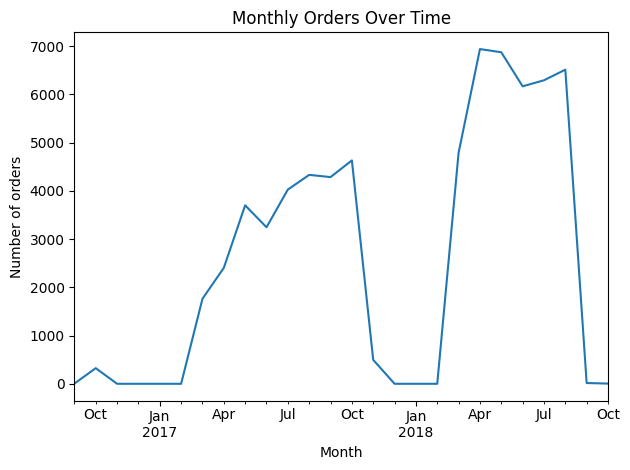

In [22]:
monthly_orders = (
    orders
    .set_index("order_purchase_ts")
    .resample("ME")["order_id"]
    .count()
)

ax = monthly_orders.plot(title="Monthly Orders Over Time")
ax.set_xlabel("Month")
ax.set_ylabel("Number of orders")
plt.tight_layout()
plt.show()

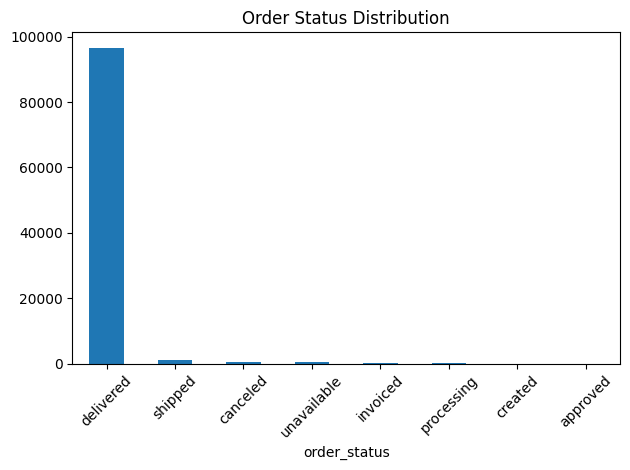

In [23]:
orders["order_status"].value_counts().plot(kind="bar", title="Order Status Distribution")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

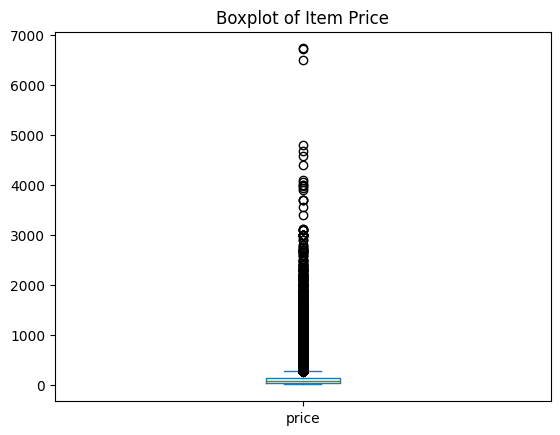

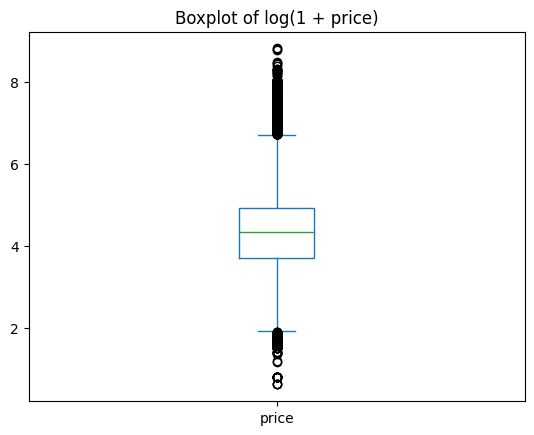

In [24]:
order_items["price"].plot(kind="box")
plt.title("Boxplot of Item Price")
plt.show()

# If extreme skew:
order_items["price"].apply(lambda x: np.log1p(x)).plot(kind="box")
plt.title("Boxplot of log(1 + price)")
plt.show()

In [25]:
events = load_table("hpce.rees46_events")
basic_eda(events, "rees46_events")

=== rees46_events ===
Shape: (2473739, 5)

Dtypes:
event_time        object
user_id           object
event_type        object
product_id        object
transaction_id    object
dtype: object

Missing values (count):
event_time        0
user_id           0
event_type        0
product_id        0
transaction_id    0
dtype: int64

Missing values (%):
event_time        0.0
user_id           0.0
event_type        0.0
product_id        0.0
transaction_id    0.0
dtype: float64

Value counts for event_time (top 5):
event_time
2017-07-01 00:42:00-07:00    35
2017-01-09 01:10:00-08:00    34
2017-02-28 00:28:00-08:00    34
2017-11-24 00:15:00-08:00    34
2017-02-24 02:57:00-08:00    33
Name: count, dtype: int64

Value counts for user_id (top 5):
user_id
fc3d1daec319d62d49bfb5e1f83123e9    162
be1b70680b9f9694d8c70f41fa3dc92b    159
bd5d39761aa56689a265d95d8d32b8be    149
adb32467ecc74b53576d9d13a5a55891    126
e7d6802668de6e74d0d6c56565bf2a24    118
Name: count, dtype: int64

Value counts for even

In [26]:
events.columns

Index(['event_time', 'user_id', 'event_type', 'product_id', 'transaction_id'], dtype='object')

In [27]:
events.head(10)

,event_time,user_id,event_type,product_id,transaction_id
0,2016-09-05 01:21:19-07:00,08c5351a6aca1c1589a38f244edeee9d,c1488892604e4ba5cff5b4eb4d595400,view,sess_cf5fc7c73fac4945
1,2016-09-05 01:31:19-07:00,08c5351a6aca1c1589a38f244edeee9d,f293394c72c9b5fafd7023301fc21fc2,view,sess_124cf35d9bc34507
2,2016-09-05 01:32:19-07:00,08c5351a6aca1c1589a38f244edeee9d,f293394c72c9b5fafd7023301fc21fc2,view,sess_124cf35d9bc34507
3,2016-09-05 01:53:19-07:00,08c5351a6aca1c1589a38f244edeee9d,f293394c72c9b5fafd7023301fc21fc2,view,sess_124cf35d9bc34507
4,2016-09-05 02:31:19-07:00,08c5351a6aca1c1589a38f244edeee9d,f293394c72c9b5fafd7023301fc21fc2,view,sess_124cf35d9bc34507
5,2016-09-05 02:45:19-07:00,08c5351a6aca1c1589a38f244edeee9d,f293394c72c9b5fafd7023301fc21fc2,view,sess_124cf35d9bc34507
6,2016-09-05 03:11:19-07:00,08c5351a6aca1c1589a38f244edeee9d,f293394c72c9b5fafd7023301fc21fc2,view,sess_124cf35d9bc34507
7,2016-09-05 03:18:19-07:00,08c5351a6aca1c1589a38f244edeee9d,c1488892604e4ba5cff5b4eb4d595400,view,sess_cf5fc7c73fac4945
8,2016-09-05 03:34:19-07:00,08c5351a6aca1c1589a38f244edeee9d,f293394c72c9b5fafd7023301fc21fc2,view,sess_124cf35d9bc34507
9,2016-09-05 03:46:19-07:00,08c5351a6aca1c1589a38f244edeee9d,c1488892604e4ba5cff5b4eb4d595400,view,sess_cf5fc7c73fac4945


In [28]:
if "event_time" in events.columns:
    events["event_time"] = pd.to_datetime(events["event_time"], errors="coerce")

events["event_time"].isna().sum()

np.int64(812244)

In [29]:
events.isna().sum().sort_values(ascending=False)
(events.isna().mean() * 100).round(2)

event_time        32.83
user_id            0.00
event_type         0.00
product_id         0.00
transaction_id     0.00
dtype: float64

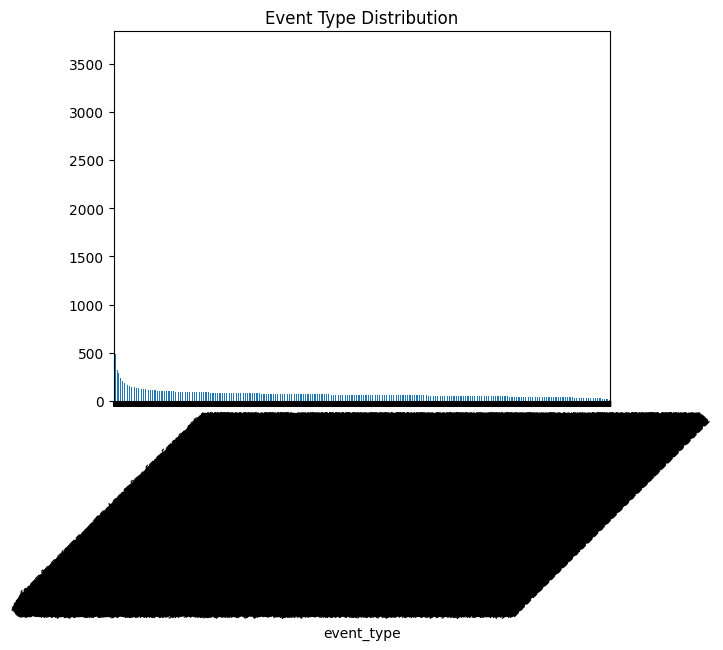

In [30]:
if "event_type" in events.columns:
    events["event_type"].value_counts().plot(kind="bar", title="Event Type Distribution")
    plt.xticks(rotation=45)
    plt.show()

In [31]:
if "user_id" in events.columns:
    events_per_customer = events["user_id"].value_counts()
    events_per_customer.describe()

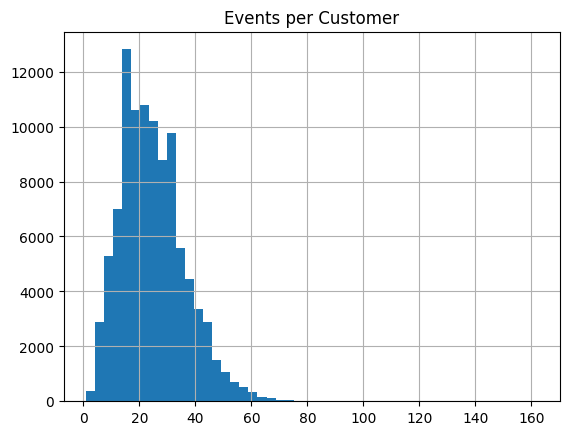

In [32]:
events_per_customer.hist(bins=50)
plt.title("Events per Customer")
plt.show()

In [40]:
events_sorted = events.sort_values(by=["user_id", "event_time"])
events_sorted.head()

,event_time,user_id,event_type,product_id,transaction_id
19584,2017-01-07 00:32:00-08:00,00012a2ce6f8dcda20d059ce98491703,b04aad9dbf15eae09db4376ff7590cff,view,sess_cd18d3e2fa6442f4
19622,2017-01-07 00:34:00-08:00,00012a2ce6f8dcda20d059ce98491703,b04aad9dbf15eae09db4376ff7590cff,view,sess_cd18d3e2fa6442f4
20390,2017-01-07 01:22:00-08:00,00012a2ce6f8dcda20d059ce98491703,b04aad9dbf15eae09db4376ff7590cff,view,sess_cd18d3e2fa6442f4
20512,2017-01-07 01:30:00-08:00,00012a2ce6f8dcda20d059ce98491703,b04aad9dbf15eae09db4376ff7590cff,view,sess_cd18d3e2fa6442f4
20604,2017-01-07 01:37:00-08:00,00012a2ce6f8dcda20d059ce98491703,b04aad9dbf15eae09db4376ff7590cff,view,sess_cd18d3e2fa6442f4


In [34]:
events["event_time"].dt.year.value_counts().sort_index()

event_time
2016.0      2373
2017.0    896404
2018.0    762718
Name: count, dtype: int64

In [35]:
missing_products = events[~events["product_id"].isin(products["product_id"])]
len(missing_products)

2473739

In [36]:
duplicate_events = events.duplicated().sum()
duplicate_events

np.int64(571421)

In [37]:
if "session_id" in events.columns:
    session_counts = events["session_id"].value_counts()
    session_counts.describe()

In [38]:
spam_users = events_per_customer[events_per_customer > events_per_customer.quantile(0.999)]
spam_users

user_id
fc3d1daec319d62d49bfb5e1f83123e9    162
be1b70680b9f9694d8c70f41fa3dc92b    159
bd5d39761aa56689a265d95d8d32b8be    149
adb32467ecc74b53576d9d13a5a55891    126
e7d6802668de6e74d0d6c56565bf2a24    118
                                   ... 
6bc8bdbe0e04893baa7dc040bc8b15bc     75
b0122e56650079ca699d17446a11bfbb     75
0916acefe664698288f758bbf549a53e     75
dcdc9c7e585f8d8992ea33d72b924a64     75
d22f25a9fadfb1abbc2e29395b1239f4     75
Name: count, Length: 96, dtype: int64